### Turing.ml example: https://turing.ml/dev/tutorials/10-bayesian-differential-equations/ 

In [ ]:
using Turing, Distributions, DifferentialEquations

# Import MCMCChain, Plots, and StatsPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# Set a seed for reproducibility.
using Random
Random.seed!(14);

In [ ]:
function lotka_volterra(du,u,p,t)
    x, y = u
    α, β, γ, δ  = p
    du[1] = (α - β*y)x # dx =
    du[2] = (δ*x - γ)y # dy =
end
p = [1.5, 1.0, 3.0, 1.0]
u0 = [1.0,1.0]
prob1 = ODEProblem(lotka_volterra,u0,(0.0,10.0),p)
sol = solve(prob1,Tsit5())
plot(sol)

sol1 = solve(prob1,Tsit5(),saveat=0.1)
odedata = Array(sol1) + 0.8 * randn(size(Array(sol1)))
plot(sol1, alpha = 0.3, legend = false); scatter!(sol1.t, odedata')

In [ ]:
Turing.setadbackend(:forwarddiff)

@model function fitlv(data, prob1)
    σ ~ InverseGamma(2, 3) # ~ is the tilde character
    α ~ truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.5),0,2)
    γ ~ truncated(Normal(3.0,0.5),1,4)
    δ ~ truncated(Normal(1.0,0.5),0,2)

    p = [α,β,γ,δ]
    prob = remake(prob1, p=p)
    predicted = solve(prob,Tsit5(),saveat=0.1)

    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end

model = fitlv(odedata, prob1)

# This next command runs 3 independent chains without using multithreading.
chain = mapreduce(c -> sample(model, NUTS(.65),1000), chainscat, 1:3)
plot(chain)

In [ ]:
pl = scatter(sol1.t, odedata');
chain_array = Array(chain)
for k in 1:300
    resol = solve(remake(prob1,p=chain_array[rand(1:1500), 1:4]),Tsit5(),saveat=0.1)
    plot!(resol, alpha=0.1, color = "#BBBBBB", legend = false)
end
# display(pl)
plot!(sol1, w=1, legend = false)

# troubleshooting transporter model



In [ ]:
using Catalyst, DifferentialEquations, StatsPlots, Plots, DataFrames, CSV, Random, Turing, Latexify, ModelingToolkit, DynamicHMC
using ModelingToolkit: varmap_to_vars
using Optim, Noise, AdvancedMH, MCMCChains, StatsBase, Sundials
using BenchmarkTools

function gen_∂logπ∂θ(vi, spl, model)
    function ∂logπ∂θ(x)
        return Turing.Core.gradient_logp(x, vi, model, spl)
    end
    return ∂logπ∂θ
end

function test_gradient(model)
    var_info = Turing.VarInfo(model)
    ctx = Turing.DefaultContext()

    spl = DynamicPPL.Sampler(NUTS(.65))
    DynamicPPL.link!(var_info, spl)

    ∂logπ∂θ = gen_∂logπ∂θ(var_info, spl, model)
    return ∂logπ∂θ, var_info[spl]
end


# Normal log-likelihood calculation
function calc_norm_log_likelihood(mu,sigma,X)
    # Normal log-likelihood function: -[(n/2)ln(2pp*sigma^2)]-[sum((X-mu)^2)/(2*sigma^2)]
    # ref: https://www.statlect.com/fundamentals-of-statistics/normal-distribution-maximum-likelihood 
    n = length(X)
    f1 = -1*(n/2)*log(2*pi*sigma^2)
    f2_a = -1/(2*sigma^2)
    f2_b = 0 
    for i in 1:n
        f2_b += (X[i]-mu[i])^2
    end
    f2 = f2_a*f2_b
    log_likelihood = f1+f2
end

# flux calculation function
function calc_flux(p,u,v)
    flux_in = v*(p[1]*u[1])
    flux_out = v*(p[2]*u[2].*u[3])
    net_flux = flux_in - flux_out         
end

Random.seed!(14)
sigma_f = 1
t_short = false

# define reaction network in Catalyst
rn = @reaction_network begin
  (k1_f*H_out, k1_r), OF <--> OF_Hb
  (k2_f, k2_r), OF_Hb <--> IF_Hb
  (k3_f, k3_r), IF_Hb + S_in <--> IF_Hb_Sb
  (k4_f, k4_r), IF_Hb_Sb <--> IF_Sb + H_in
  (k5_f, k5_r), IF_Sb <--> OF_Sb
  (k6_f, k6_r*S_out), OF_Sb <--> OF
end H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r

# convert reaction network to ODEsystem
odesys = convert(ODESystem, rn)

# define initial variable values and parameters
H_out_ref = 1e-7
S_out_ref = 1e-3
stdev_ref = sigma_f*1e-13
@parameters  H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r stdev_s
@variables t H_in(t) S_in(t) OF(t) OF_Hb(t) IF_Hb(t) IF_Hb_Sb(t) IF_Sb(t) OF_Sb(t)
u0map = [H_in => 1e-7, S_in => 1e-3, 
        OF => 2.833e-8, OF_Hb => 2.833e-8,  
        IF_Hb => 2.833e-8, IF_Hb_Sb => 2.833e-8,
        IF_Sb => 2.125e-8, OF_Sb => 2.125e-8, 
        ]
pmap = [H_out => H_out_ref, S_out => S_out_ref,
        k1_f =>1e10, k1_r =>1e3,
        k2_f =>1e2, k2_r =>1e2,
        k3_f =>1e7, k3_r =>1e3,
        k4_f =>1e3, k4_r =>1e10,
        k5_f =>1e2, k5_r =>1e2,
        k6_f =>1e3, k6_r =>1e7
        ]

# create ODEproblem w/ timed events discrete callback
if t_short == true
    t_sample = 0.4
else
    t_sample = 0.04
end    
tspan1 = (0.0,15)
oprob = ODEProblem(odesys, u0map, tspan1, pmap)
event_times = [5.0,10.0]
condition(u,t,integrator) = t ∈ event_times
function affect!(integrator)
    if integrator.t == 5.0
        integrator.p[1] = 5e-8
    elseif integrator.t == 10.0
        integrator.p[1] = 1e-7
    end
end
cb = DiscreteCallback(condition,save_positions=(false, false), affect!)

atol=1e-18
rtol=1e-15

# get y_true and y_obs
# s_true = solve(oprob, CVODE_BDF(), abstol = 1e-18, reltol = 1e-12, saveat=t_sample, callback=cb, tstops=event_times)
s_true = solve(oprob, TRBDF2(), abstol = atol, reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times)
@btime solve(oprob,TRBDF2(),abstol = atol,  reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times) 
@btime solve(oprob,RadauIIA5(),abstol = atol,  reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times) 
@btime solve(oprob, KenCarp4(), abstol = atol, reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times) 
@btime solve(oprob,CVODE_BDF(), abstol = atol, reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times) 


k_true = [pmap[9][2], pmap[10][2]]
c_true = [s_true[IF_Hb_Sb], s_true[H_in], s_true[IF_Sb]]
vol = 0.0001
y_true = calc_flux(k_true,c_true,vol)


# y_obs = add_gauss(y_true,stdev_ref)
# df = DataFrame(data = y_obs)
# CSV.write("data_grid_test3.csv", df)
df2 = CSV.read("data_grid_test3.csv", DataFrame)
y_obs = df2[!, "data"]

ref_log_likelihood = calc_norm_log_likelihood(y_obs,stdev_ref,y_true)

println(length(y_obs))
println(ref_log_likelihood)


##### sampling
println("sampling...")
# create Turing model w/ forward differentiation
Turing.setadbackend(:forwarddiff)
@model function rxn_sampler(data, prob, sys)
    
    
    log_stdev_sample2 ~ Uniform(log10(5e-14), log10(5e-13))
    
    log_k1_f ~ Uniform(6,12) # log10 rate constant (ref=1e10)
    log_k1_r ~ Uniform(-1,5)  # log10 rate constant (ref=1e3)  
    
    log_k2_f ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
    log_k2_r ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
    
    log_k3_f ~ Uniform(3,9)  # log10 rate constant (ref=1e7) 
    log_k3_r ~ Uniform(-1,5)  # log10 rate constant (ref=1e3) 
    
    log_k4_f ~ Uniform(-1,5)  # log10 rate constant (ref=1e3) 
    log_k4_r ~ Uniform(6,12)  # log10 rate constant (ref=1e10)
    
    log_k5_f ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
    log_k5_r ~ Uniform(-2,4)   # log10 rate constant (ref=1e2)
    
    log_k6_f ~ Uniform(-1,5)  # log10  rate constant (ref=1e3)
    
    # set parameter values and initial concentrations
    log_k6_r = (log_k1_f+log_k2_f+log_k3_f+log_k4_f+log_k5_f+log_k6_f)-(log_k1_r+log_k2_r+log_k3_r+log_k4_r+log_k5_r) 
    pmap2 = [H_out => H_out_ref, S_out => S_out_ref,
            k1_f =>10.0^log_k1_f, k1_r =>10.0^log_k1_r,
            k2_f =>10.0^log_k2_f, k2_r =>10.0^log_k2_r,
            k3_f =>10.0^log_k3_f, k3_r =>10.0^log_k3_r,
            k4_f =>10.0^log_k4_f, k4_r =>10.0^log_k4_r,
            k5_f =>10.0^log_k5_f, k5_r =>10.0^log_k5_r,
            k6_f =>10.0^log_k6_f, k6_r =>10.0^log_k6_r,
    ]
    
    # solve ODE system
    pnew2 = varmap_to_vars(pmap2, parameters(sys))
    oprob2 = remake(prob, p=pnew2)
    #sol2 = solve(oprob2, TRBDF2(), abstol = 1e-18, reltol = 1e-12, saveat=0.04, callback=cb, tstops=event_times)
    sol2 = solve(oprob2, TRBDF2(), abstol = atol, reltol = rtol, saveat=0.04, callback=cb, tstops=event_times)
    
    # calc flux (y_pred)
    k2 = [pmap2[9][2], pmap2[10][2]]
    c2 = [sol2[IF_Hb_Sb], sol2[H_in], sol2[IF_Sb]]
    vol = 0.0001
    y_pred2 = calc_flux(k2,c2,vol)
    
    for i = 1:length(data)
        data[i] ~ Normal(y_pred2[i], 10^log_stdev_sample2)
    end
end

model = rxn_sampler(y_obs, oprob, odesys)

c =sample(model, NUTS(.65),1000)

# #model = fit(...)
# ∇, vi = test_gradient(model);
# ∇(vi)


# # Use NelderMead
# mle_estimate1 = optimize(model, MLE(), NelderMead(), Optim.Options(iterations = 10_000, allow_f_increases=true, g_tol=atol))

# # Use SimulatedAnnealing
# mle_estimate2 = optimize(model, MLE(), SimulatedAnnealing(), Optim.Options(iterations = 10_000, allow_f_increases=true, g_tol=atol))

# # Use ParticleSwarm
# mle_estimate3 = optimize(model, MLE(), ParticleSwarm(), Optim.Options(iterations = 10_000, allow_f_increases=true, g_tol=atol))

# # Use Newton
# #mle_estimate4 = optimize(model, MLE(), Newton())

# # Use AcceleratedGradientDescent
# mle_estimate5 = optimize(model, MLE(), AcceleratedGradientDescent(), Optim.Options(iterations = 10_000, allow_f_increases=true, g_tol=atol))

# println(mle_estimate1.values.array)
# println(mle_estimate2.values.array)
# println(mle_estimate3.values.array)
# #println(mle_estimate4.values.array)
# println(mle_estimate5.values.array)

In [ ]:
plot(y_true, ylim=(-1.5e-11, 1.5e-11));scatter!(y_obs, alpha=0.25)

In [ ]:
using Pathfinder

iter=1_000

# Use NelderMead
#mle_estimate1 = optimize(model, MLE(), NelderMead(), Optim.Options(iterations = iter, allow_f_increases=true, g_tol=atol))


# # Use SimulatedAnnealing
# mle_estimate2 = optimize(model, MLE(), SimulatedAnnealing(), Optim.Options(iterations = iter, allow_f_increases=true, g_tol=atol))

# # Use ParticleSwarm
# mle_estimate3 = optimize(model, MLE(), ParticleSwarm(), Optim.Options(iterations = iter, allow_f_increases=true, g_tol=atol))

# # Use Newton
# #mle_estimate4 = optimize(model, MLE(), Newton())

# # Use AcceleratedGradientDescent
# mle_estimate5 = optimize(model, MLE(), AcceleratedGradientDescent(), Optim.Options(iterations = iter, allow_f_increases=true, g_tol=atol))

#println(mle_estimate1.values.array)
# println(mle_estimate2.values.array)
# println(mle_estimate3.values.array)
# #println(mle_estimate4.values.array)
# println(mle_estimate5.values.array)


result_multi = multipathfinder(model, 1_000; nruns=10)

In [ ]:
result_multi.draws_transformed

In [ ]:
using AdvancedHMC, Distributions, ForwardDiff
using LinearAlgebra, Plots

# Choose parameter dimensionality and initial parameter value
D = 12; initial_θ = rand(D)

# Define the target distribution
ℓπ(θ) = logpdf(MvNormal(zeros(D), I), θ)

# Set the number of samples to draw and warmup iterations
n_samples, n_adapts = 2_000, 1_000

# Define a Hamiltonian system
metric = DiagEuclideanMetric(D)
hamiltonian = Hamiltonian(metric, ℓπ, ForwardDiff)

# Define a leapfrog solver, with initial step size chosen heuristically
initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
integrator = Leapfrog(initial_ϵ)

# Define an HMC sampler, with the following components
#   - multinomial sampling scheme,
#   - generalised No-U-Turn criteria, and
#   - windowed adaption for step-size and diagonal mass matrix
proposal = NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))

# Run the sampler to draw samples from the specified Gaussian, where
#   - `samples` will store the samples
#   - `stats` will store diagnostic statistics for each sample
samples, stats = sample(hamiltonian, proposal, initial_θ, n_samples, adaptor, n_adapts; progress=true)


### advancedHMC using ODEs

In [ ]:
using AdvancedHMC, Distributions, ForwardDiff
using LinearAlgebra

# Choose parameter dimensionality and initial parameter value
D = 10; initial_θ = rand(D)

# Define the target distribution
ℓπ(θ) = logpdf(MvNormal(zeros(D), I), θ)

# Set the number of samples to draw and warmup iterations
n_samples, n_adapts = 2_000, 1_000

# Define a Hamiltonian system
metric = DiagEuclideanMetric(D)
hamiltonian = Hamiltonian(metric, ℓπ, ForwardDiff)

# Define a leapfrog solver, with initial step size chosen heuristically
initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
integrator = Leapfrog(initial_ϵ)

# Define an HMC sampler, with the following components
#   - multinomial sampling scheme,
#   - generalised No-U-Turn criteria, and
#   - windowed adaption for step-size and diagonal mass matrix
proposal = NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))

# Run the sampler to draw samples from the specified Gaussian, where
#   - `samples` will store the samples
#   - `stats` will store diagnostic statistics for each sample
samples, stats = sample(hamiltonian, proposal, initial_θ, n_samples, adaptor, n_adapts; progress=true)

#### sampling

In [ ]:
using DiffEqFlux, DifferentialEquations, Plots, AdvancedHMC, MCMCChains
using JLD, StatsPlots

u0 = [2.0; 0.0]
datasize = 40
tspan = (0.0, 1)
tsteps = range(tspan[1], tspan[2], length = datasize)

function trueODEfunc(du, u, p, t)
    true_A = [-0.1 2.0; -2.0 -0.1]
    du .= ((u.^3)'true_A)'
end

prob_trueode = ODEProblem(trueODEfunc, u0, tspan)
ode_data = Array(solve(prob_trueode, Tsit5(), saveat = tsteps))


dudt2 = FastChain((x, p) -> x.^3,
                  FastDense(2, 50, tanh),
                  FastDense(50, 2))
prob_neuralode = NeuralODE(dudt2, tspan, Tsit5(), saveat = tsteps)

function predict_neuralode(p)
    Array(prob_neuralode(u0, p))
end

function loss_neuralode(p)
    pred = predict_neuralode(p)
    loss = sum(abs2, ode_data .- pred)
    return loss, pred
end

l(θ) = -sum(abs2, ode_data .- predict_neuralode(θ)) - sum(θ .* θ)


function dldθ(θ)
    x,lambda = Flux.Zygote.pullback(l,θ)
    grad = first(lambda(1))
    return x, grad
end

metric  = DiagEuclideanMetric(length(prob_neuralode.p))

h = Hamiltonian(metric, l, dldθ)


integrator = Leapfrog(find_good_stepsize(h, Float64.(prob_neuralode.p)))


prop = AdvancedHMC.NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)

adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.45, integrator))

samples, stats = sample(h, prop, Float64.(prob_neuralode.p), 500, adaptor, 500; progress=true)


losses = map(x-> x[1],[loss_neuralode(samples[i]) for i in 1:length(samples)])

##################### PLOTS: LOSSES ###############
scatter(losses, ylabel = "Loss",  yscale= :log, label = "Architecture1: 500 warmup, 500 sample")

################### RETRODICTED PLOTS: TIME SERIES #################
pl = scatter(tsteps, ode_data[1,:], color = :red, label = "Data: Var1", xlabel = "t", title = "Spiral Neural ODE")
scatter!(tsteps, ode_data[2,:], color = :blue, label = "Data: Var2")

for k in 1:300
    resol = predict_neuralode(samples[100:end][rand(1:400)])
    plot!(tsteps,resol[1,:], alpha=0.04, color = :red, label = "")
    plot!(tsteps,resol[2,:], alpha=0.04, color = :blue, label = "")
end

idx = findmin(losses)[2]
prediction = predict_neuralode(samples[idx])

plot!(tsteps,prediction[1,:], color = :black, w = 2, label = "")
plot!(tsteps,prediction[2,:], color = :black, w = 2, label = "Best fit prediction", ylims = (-2.5, 3.5))



#################### RETRODICTED PLOTS - CONTOUR ####################
pl = scatter(ode_data[1,:], ode_data[2,:], color = :red, label = "Data",  xlabel = "Var1", ylabel = "Var2", title = "Spiral Neural ODE")

for k in 1:300
    resol = predict_neuralode(samples[100:end][rand(1:400)])
    plot!(resol[1,:],resol[2,:], alpha=0.04, color = :red, label = "")
end

plot!(prediction[1,:], prediction[2,:], color = :black, w = 2, label = "Best fit prediction", ylims = (-2.5, 3))


# 5/22/2022

### import packages, define functions, and create reaction model 

In [1]:
using Catalyst, DifferentialEquations, StatsPlots, Plots, DataFrames, CSV, Random, Latexify, ModelingToolkit, DynamicHMC
using ModelingToolkit: varmap_to_vars
using Optim, Noise, AdvancedMH, MCMCChains, StatsBase, Sundials
using BenchmarkTools
using AdvancedHMC, Distributions, ForwardDiff
using LinearAlgebra, Plots, Pathfinder, Turing, Optim, MCMCTempering, NestedSamplers


# Normal log-likelihood calculation
function calc_norm_log_likelihood(mu,sigma,X)
    # Normal log-likelihood function: -[(n/2)ln(2pp*sigma^2)]-[sum((X-mu)^2)/(2*sigma^2)]
    # ref: https://www.statlect.com/fundamentals-of-statistics/normal-distribution-maximum-likelihood 
    n = length(X)
    f1 = -1*(n/2)*log(2*pi*sigma^2)
    f2_a = -1/(2*sigma^2)
    f2_b = 0 
    for i in 1:n
        f2_b += (X[i]-mu[i])^2
    end
    f2 = f2_a*f2_b
    log_likelihood = f1+f2
end


# flux calculation function
function calc_flux(p,u,v)
    flux_in = v*(p[1]*u[1])
    flux_out = v*(p[2]*u[2].*u[3])
    net_flux = flux_in - flux_out
    net_flux_trim = net_flux[2:end]
end


# define reaction network in Catalyst
rn = @reaction_network begin
  (k1_f*H_out, k1_r), OF <--> OF_Hb
  (k2_f, k2_r), OF_Hb <--> IF_Hb
  (k3_f, k3_r), IF_Hb + S_in <--> IF_Hb_Sb
  (k4_f, k4_r), IF_Hb_Sb <--> IF_Sb + H_in
  (k5_f, k5_r), IF_Sb <--> OF_Sb
  (k6_f, k6_r*S_out), OF_Sb <--> OF
end H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r

# convert reaction network to ODEsystem
odesys = convert(ODESystem, rn)

Model ##ReactionSystem#307 with 8 equations
States (8):
  OF(t)
  OF_Hb(t)
  IF_Hb(t)
  S_in(t)
  IF_Hb_Sb(t)
  IF_Sb(t)
⋮
Parameters (14):
  H_out
  S_out
  k1_f
  k1_r
  k2_f
  k2_r
⋮

### generate synthetic data and calculate steady state populations

synthetic model settings:
  sigma=1.0e-13
  parameter values (steady state)=Pair{Num, Float64}[H_out => 5.0e-8, S_out => 0.001, k1_f => 1.0e10, k1_r => 1000.0, k2_f => 100.0, k2_r => 100.0, k3_f => 1.0e7, k3_r => 1000.0, k4_f => 1000.0, k4_r => 1.0e10, k5_f => 100.0, k5_r => 100.0, k6_f => 1000.0, k6_r => 1.0e7]
  initial populations (steady state)=Pair{Num, Float64}[H_in(t) => 1.0000006654560167e-7, S_in(t) => 0.000999981111790563, OF(t) => 4.721819523811756e-9, OF_Hb(t) => 4.721827051893435e-9, IF_Hb(t) => 4.721902739690265e-9, IF_Hb_Sb(t) => 4.721814289120632e-8, IF_Sb(t) => 4.721812001753802e-8, OF_Sb(t) => 4.7218187775823155e-8]

ODE settings:
  atol=1.0e-18
  rtol=1.0e-15
  sample rate=1 sample / 0.04 seconds
  t span=(0.0, 4.0)
  t events=[2]

synthetic data settings:
  random seed=14
  n data points=302
  reference log likelihood: 8621.248104483839



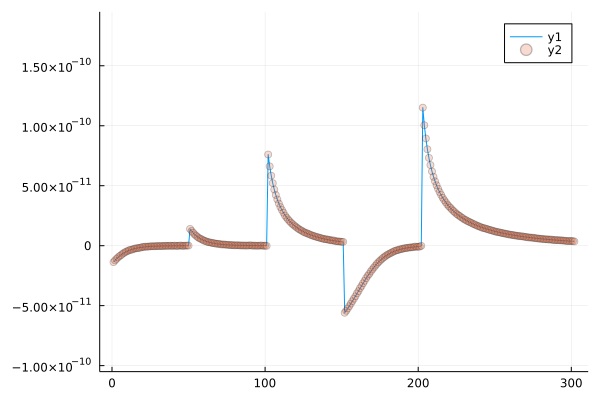

In [131]:
# set buffer solution concentrations, sigma ref, ODE sample rate, ODE tspan, ODE tolerance, random seed
H_out_ref = 1e-7
S_out_ref = 1e-3

### refactor this!
H_out_activation = 5e-8
S_out_activation = 1e-3
H_out_activation2 = 5e-7
S_out_activation2 = 1e-3
H_out_activation3 = 1e-7
S_out_activation3 = 1e-4

stdev_ref = 1e-13
t_sample = 0.04    
tspan1 = (0.0,4.0)
atol=1e-18
rtol=1e-15
seed = 14
Random.seed!(seed)

# define initial variable values and parameters
@parameters  H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r stdev_s
@variables t H_in(t) S_in(t) OF(t) OF_Hb(t) IF_Hb(t) IF_Hb_Sb(t) IF_Sb(t) OF_Sb(t)
u0map = [H_in => 1e-7, S_in => 1e-3, 
        OF => 2.833e-8, OF_Hb => 2.833e-8,  
        IF_Hb => 2.833e-8, IF_Hb_Sb => 2.833e-8,
        IF_Sb => 2.125e-8, OF_Sb => 2.125e-8, 
        ]
pmap = [H_out => H_out_ref, S_out => S_out_ref,
        k1_f =>1e10, k1_r =>1e3,
        k2_f =>1e2, k2_r =>1e2,
        k3_f =>1e7, k3_r =>1e3,
        k4_f =>1e3, k4_r =>1e10,
        k5_f =>1e2, k5_r =>1e2,
        k6_f =>1e3, k6_r =>1e7
        ]

# get steady state populations
oprob = ODEProblem(odesys, u0map, tspan1, pmap,)
sol_ss = solve(oprob, DynamicSS(TRBDF2(), atol, rtol))

# update initial populations and parameter values
u0map_ss = [H_in => sol_ss[H_in][end], S_in => sol_ss[S_in][end], 
        OF => sol_ss[OF][end], OF_Hb => sol_ss[OF_Hb][end],  
        IF_Hb => sol_ss[IF_Hb][end], IF_Hb_Sb => sol_ss[IF_Hb_Sb][end],
        IF_Sb => sol_ss[IF_Sb][end], OF_Sb => sol_ss[OF_Sb][end], 
        ]

pmap_ss = [H_out => H_out_activation, S_out => S_out_activation,
        k1_f =>1e10, k1_r =>1e3,
        k2_f =>1e2, k2_r =>1e2,
        k3_f =>1e7, k3_r =>1e3,
        k4_f =>1e3, k4_r =>1e10,
        k5_f =>1e2, k5_r =>1e2,
        k6_f =>1e3, k6_r =>1e7
        ]

pmap_ss2 = [H_out => H_out_activation2, S_out => S_out_activation2,
        k1_f =>1e10, k1_r =>1e3,
        k2_f =>1e2, k2_r =>1e2,
        k3_f =>1e7, k3_r =>1e3,
        k4_f =>1e3, k4_r =>1e10,
        k5_f =>1e2, k5_r =>1e2,
        k6_f =>1e3, k6_r =>1e7
        ]

pmap_ss3 = [H_out => H_out_activation3, S_out => S_out_activation3,
        k1_f =>1e10, k1_r =>1e3,
        k2_f =>1e2, k2_r =>1e2,
        k3_f =>1e7, k3_r =>1e3,
        k4_f =>1e3, k4_r =>1e10,
        k5_f =>1e2, k5_r =>1e2,
        k6_f =>1e3, k6_r =>1e7
        ]

# create discrete callback (timed events) and solve ODE problem
event_times = [2]
condition(u,t,integrator) = t ∈ event_times
function affect!(integrator)
    if integrator.t == 2.0
        integrator.p[1] = 1e-7
    end
end
cb = DiscreteCallback(condition,save_positions=(false, false), affect!)
oprob_ss = ODEProblem(odesys, u0map_ss, tspan1, pmap_ss,)
oprob_ss2 = ODEProblem(odesys, u0map_ss, tspan1, pmap_ss2,)
oprob_ss3 = ODEProblem(odesys, u0map_ss, tspan1, pmap_ss3,)

# get y_true and y_obs
s_true = solve(oprob_ss, TRBDF2(), abstol = atol, reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times)
s_true2 = solve(oprob_ss2, TRBDF2(), abstol = atol, reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times)
s_true3 = solve(oprob_ss3, TRBDF2(), abstol = atol, reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times)

k_true = [pmap_ss[9][2], pmap_ss[10][2]]
c_true = [vcat(s_true[IF_Hb_Sb],s_true2[IF_Hb_Sb],s_true3[IF_Hb_Sb]), 
    vcat(s_true[H_in],s_true2[H_in],s_true3[H_in]), 
    vcat(s_true[IF_Sb],s_true2[IF_Sb],s_true3[IF_Sb])]
vol = 0.0001
y_true = calc_flux(k_true,c_true,vol)
y_obs = add_gauss(y_true,stdev_ref)
# # df = DataFrame(data = y_obs)
# # CSV.write("data_grid_test3.csv", df)
# df2 = CSV.read("data_grid_test3.csv", DataFrame)
# y_obs = df2[!, "data"]
ref_log_likelihood = calc_norm_log_likelihood(y_obs,stdev_ref,y_true)
n_data = length(y_obs)

# print out summary
println("synthetic model settings:")
println("  sigma=$stdev_ref")
println("  parameter values (steady state)=$pmap_ss")
println("  initial populations (steady state)=$u0map_ss")
println()
println("ODE settings:")
println("  atol=$atol")
println("  rtol=$rtol")
println("  sample rate=1 sample / $t_sample seconds")
println("  t span=$tspan1")
println("  t events=$event_times")
println()
println("synthetic data settings:")
println("  random seed=$seed")
println("  n data points=$n_data")
println("  reference log likelihood: $ref_log_likelihood")
println()
plot(y_true, ylim=(-10.5e-11, 19.5e-11));scatter!(y_obs, alpha=0.25)


### Turing model and get Pathfinder results (MCMC initialization)

In [ ]:
### Turing 
using ForwardDiff, Preferences
set_preferences!(ForwardDiff, "nansafe_mode" => true)

# Turing.setadbackend(:forwarddiff)
# @model function rxn_sampler(data, prob, sys)
    
#     log_stdev_sample2  ~ Uniform(log10(5e-14), log10(5e-13))
#     #log_stdev_sample2 = -13.0
    
#     log_k1_f ~ Uniform(6,12) # log10 rate constant (ref=1e10)
#     log_k1_r ~ Uniform(-1,5)  # log10 rate constant (ref=1e3)  
    
#     log_k2_f ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
#     log_k2_r ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
    
#     log_k3_f ~ Uniform(3,9)  # log10 rate constant (ref=1e7) 
#     log_k3_r ~ Uniform(-1,5)  # log10 rate constant (ref=1e3) 
    
#     log_k4_f ~ Uniform(-1,5)  # log10 rate constant (ref=1e3) 
#     log_k4_r ~ Uniform(6,12)  # log10 rate constant (ref=1e10)
    
#     log_k5_f ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
#     log_k5_r ~ Uniform(-2,4)   # log10 rate constant (ref=1e2)
    
#     log_k6_f ~ Uniform(-1,5)  # log10  rate constant (ref=1e3)
#     log_k6_r = (log_k1_f+log_k2_f+log_k3_f+log_k4_f+log_k5_f+log_k6_f)-(log_k1_r+log_k2_r+log_k3_r+log_k4_r+log_k5_r) 
    
    
# #     log_stdev_sample2_norm  ~ Uniform(0, 1)   
# #     log_k1_f_norm ~ Uniform(0,1) # log10 rate constant (ref=1e10)
# #     log_k1_r_norm ~ Uniform(0,1)  # log10 rate constant (ref=1e3)     
# #     log_k2_f_norm  ~ Uniform(0,1)  # log10 rate constant (ref=1e2)
# #     log_k2_r_norm  ~ Uniform(0,1)  # log10 rate constant (ref=1e2)    
# #     log_k3_f_norm  ~ Uniform(0,1)  # log10 rate constant (ref=1e7) 
# #     log_k3_r_norm  ~ Uniform(0,1)  # log10 rate constant (ref=1e3)     
# #     log_k4_f_norm  ~ Uniform(0,1)  # log10 rate constant (ref=1e3) 
# #     log_k4_r_norm  ~ Uniform(0,1)  # log10 rate constant (ref=1e10)   
# #     log_k5_f_norm  ~ Uniform(0,1)  # log10 rate constant (ref=1e2)
# #     log_k5_r_norm  ~ Uniform(0,1)   # log10 rate constant (ref=1e2)   
# #     log_k6_f_norm  ~ Uniform(0,1)  # log10  rate constant (ref=1e3)   
# #     log_stdev_sample2  = log_stdev_sample2_norm*(log10(5e-13)-log(5e-14))+log(5e-14)
    
# #     log_k1_f = log_k1_f_norm*6 +6
# #     log_k1_r = log_k1_r_norm*6 -1   
# #     log_k2_f = log_k2_f_norm*6 -2
# #     log_k2_r = log_k2_r_norm*6 -2   
# #     log_k3_f = log_k3_f_norm*6 +3
# #     log_k3_r = log_k3_r_norm*6 -1    
# #     log_k4_f = log_k4_f_norm*6 -1
# #     log_k4_r = log_k4_r_norm*6 +6   
# #     log_k5_f = log_k5_f_norm*6 -2
# #     log_k5_r = log_k5_r_norm*6 -2 
# #     log_k6_f = log_k6_f_norm*6 -1
# #     log_k6_r = (log_k1_f+log_k2_f+log_k3_f+log_k4_f+log_k5_f+log_k6_f)-(log_k1_r+log_k2_r+log_k3_r+log_k4_r+log_k5_r) 
    
#     # set parameter values and initial concentrations
#     pmap2 = [H_out => H_out_activation, S_out => S_out_activation,
#             k1_f =>10.0^log_k1_f, k1_r =>10.0^log_k1_r,
#             k2_f =>10.0^log_k2_f, k2_r =>10.0^log_k2_r,
#             k3_f =>10.0^log_k3_f, k3_r =>10.0^log_k3_r,
#             k4_f =>10.0^log_k4_f, k4_r =>10.0^log_k4_r,
#             k5_f =>10.0^log_k5_f, k5_r =>10.0^log_k5_r,
#             k6_f =>10.0^log_k6_f, k6_r =>10.0^log_k6_r,
#     ]
    
#     # solve ODE system
#     pnew2 = varmap_to_vars(pmap2, parameters(sys))
#     oprob2 = remake(prob, p=pnew2)
#     sol2 = solve(oprob2, TRBDF2(), abstol = atol, reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times)
    
#     # calc flux (y_pred)
#     k2 = [pmap2[9][2], pmap2[10][2]]
#     c2 = [sol2[IF_Hb_Sb], sol2[H_in], sol2[IF_Sb]]
#     vol = 0.0001
#     y_pred2 = calc_flux(k2,c2,vol)
    
#     for i = 1:length(data)
#         #data[i] ~ Normal(y_pred2[i], 10^log_stdev_sample2)
#         data[i] ~ Normal(y_pred2[i], 10^log_stdev_sample2)
#     end
# end

# model = rxn_sampler(y_obs, oprob_ss, odesys)
# # # c = sample(model, Turing.NUTS(),1000)
# # # plot(c)



using NestedSamplers
using Distributions
using LinearAlgebra
using StatsBase
using AdvancedHMC, Distributions, ForwardDiff
using LinearAlgebra




function calc_log_prior(theta)
    log_k1_f = theta[1]  # log10 rate constant (ref=1e10)
    log_k1_r = theta[2]  # log10 rate constant (ref=1e3)  
    
    log_k2_f = theta[3]  # log10 rate constant (ref=1e2)
    log_k2_r = theta[4]  # log10 rate constant (ref=1e2)
    
    log_k3_f = theta[5]  # log10 rate constant (ref=1e7) 
    log_k3_r = theta[6]  # log10 rate constant (ref=1e3) 
    
    log_k4_f = theta[7]  # log10 rate constant (ref=1e3) 
    log_k4_r = theta[8]  # log10 rate constant (ref=1e10)
    
    log_k5_f = theta[9]  # log10 rate constant (ref=1e2)
    log_k5_r = theta[10]  # log10 rate constant (ref=1e2)
    
    log_k6_f = theta[11]  # log10  rate constant (ref=1e3)
    log_stdev = theta[12]
    
#     if (( 6<log_k1_f && log_k1_f < 12) && (-1 < log_k1_r && log_k1_r < 5) && (-2 < log_k2_f && log_k2_f < 4) 
#         && ( -2< log_k2_r && log_k2_r< 4) && ( 3< log_k3_f && log_k3_f< 9) && (-1 < log_k3_r && log_k3_r< 5) 
#         && (-1 < log_k4_f && log_k4_f< 5) && (6 < log_k4_r && log_k4_r< 12) && (-2 < log_k5_f && log_k5_f< 4)  
#         && (-2 < log_k5_r && log_k5_r< 4) && ( -1< log_k6_f && log_k6_f< 5) 
#         && ((log10(5e-14) < log_stdev && log_stdev < log10(5e-13)))) 
#         return 0.0
#     else
#         return -Inf
#     end
    
    if (( 0<log_k1_f && log_k1_f < 1) && (0 < log_k1_r && log_k1_r < 1) && (0 < log_k2_f && log_k2_f < 1) 
        && ( 0< log_k2_r && log_k2_r< 1) && ( 0< log_k3_f && log_k3_f< 1) && (0 < log_k3_r && log_k3_r< 1) 
        && (0 < log_k4_f && log_k4_f< 1) && (0 < log_k4_r && log_k4_r< 1) && (0 < log_k5_f && log_k5_f< 1)  
        && (0 < log_k5_r && log_k5_r< 1) && ( 0< log_k6_f && log_k6_f< 1) 
        && ((0 < log_stdev && log_stdev < 1))) 
        return 0.0
    else
        return -Inf
    end
end


function log_prob(theta)
    
    log_stdev_sample2 = -1*((log10(5e-13)-log10(5e-14))*theta[12]-log10(5e-13))
    
    log_k1_f = 6*theta[1]+6  # log10 rate constant (ref=1e10)
    log_k1_r = 6*theta[2]-1  # log10 rate constant (ref=1e3)  
    
    log_k2_f = 6*theta[3]-2  # log10 rate constant (ref=1e2)
    log_k2_r = 6*theta[4]-2  # log10 rate constant (ref=1e2)
    
    log_k3_f = 6*theta[5]+3  # log10 rate constant (ref=1e7) 
    log_k3_r = 6*theta[6]-1  # log10 rate constant (ref=1e3) 
    
    log_k4_f = 6*theta[7]-1 # log10 rate constant (ref=1e3) 
    log_k4_r = 6*theta[8]+6  # log10 rate constant (ref=1e10)
    
    log_k5_f = 6*theta[9]-2  # log10 rate constant (ref=1e2)
    log_k5_r = 6*theta[10]-2  # log10 rate constant (ref=1e2)
    
    log_k6_f = 6*theta[11]-1  # log10  rate constant (ref=1e3)
    
    

#     log_stdev_sample2 = theta[12]
    
#     log_k1_f = theta[1]  # log10 rate constant (ref=1e10)
#     log_k1_r = theta[2]  # log10 rate constant (ref=1e3)  
    
#     log_k2_f = theta[3]  # log10 rate constant (ref=1e2)
#     log_k2_r = theta[4]  # log10 rate constant (ref=1e2)
    
#     log_k3_f = theta[5]  # log10 rate constant (ref=1e7) 
#     log_k3_r = theta[6]  # log10 rate constant (ref=1e3) 
    
#     log_k4_f = theta[7]  # log10 rate constant (ref=1e3) 
#     log_k4_r = theta[8]  # log10 rate constant (ref=1e10)
    
#     log_k5_f = theta[9]  # log10 rate constant (ref=1e2)
#     log_k5_r = theta[10]  # log10 rate constant (ref=1e2)
    
#     log_k6_f = theta[11]  # log10  rate constant (ref=1e3)
    
    log_k6_r = (log_k1_f+log_k2_f+log_k3_f+log_k4_f+log_k5_f+log_k6_f)-(log_k1_r+log_k2_r+log_k3_r+log_k4_r+log_k5_r)  
    sigma = 10^log_stdev_sample2
    
    pmap2 = [H_out => H_out_activation, S_out => S_out_activation,
            k1_f =>10.0^log_k1_f, k1_r =>10.0^log_k1_r,
            k2_f =>10.0^log_k2_f, k2_r =>10.0^log_k2_r,
            k3_f =>10.0^log_k3_f, k3_r =>10.0^log_k3_r,
            k4_f =>10.0^log_k4_f, k4_r =>10.0^log_k4_r,
            k5_f =>10.0^log_k5_f, k5_r =>10.0^log_k5_r,
            k6_f =>10.0^log_k6_f, k6_r =>10.0^log_k6_r,
    ]
    
    pmap2_2 = [H_out => H_out_activation2, S_out => S_out_activation2,
            k1_f =>10.0^log_k1_f, k1_r =>10.0^log_k1_r,
            k2_f =>10.0^log_k2_f, k2_r =>10.0^log_k2_r,
            k3_f =>10.0^log_k3_f, k3_r =>10.0^log_k3_r,
            k4_f =>10.0^log_k4_f, k4_r =>10.0^log_k4_r,
            k5_f =>10.0^log_k5_f, k5_r =>10.0^log_k5_r,
            k6_f =>10.0^log_k6_f, k6_r =>10.0^log_k6_r,
        ]
    
    pmap2_3 = [H_out => H_out_activation3, S_out => S_out_activation3,
            k1_f =>10.0^log_k1_f, k1_r =>10.0^log_k1_r,
            k2_f =>10.0^log_k2_f, k2_r =>10.0^log_k2_r,
            k3_f =>10.0^log_k3_f, k3_r =>10.0^log_k3_r,
            k4_f =>10.0^log_k4_f, k4_r =>10.0^log_k4_r,
            k5_f =>10.0^log_k5_f, k5_r =>10.0^log_k5_r,
            k6_f =>10.0^log_k6_f, k6_r =>10.0^log_k6_r,
        ]

    
    # solve ODE system
    pnew2 = varmap_to_vars(pmap2, parameters(odesys))
    oprob2 = remake(oprob_ss, p=pnew2)
    sol2 = solve(oprob2, TRBDF2(), abstol = atol, reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times)
    
    pnew2_2 = varmap_to_vars(pmap2_2, parameters(odesys))
    oprob2_2 = remake(oprob_ss2, p=pnew2_2)
    sol2_2 = solve(oprob2_2, TRBDF2(), abstol = atol, reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times)
    
    pnew2_3 = varmap_to_vars(pmap2_3, parameters(odesys))
    oprob2_3 = remake(oprob_ss3, p=pnew2_3)
    sol2_3 = solve(oprob2_3, TRBDF2(), abstol = atol, reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times)
    
    # calc flux (y_pred)
    k2 = [pmap2[9][2], pmap2[10][2]]
    #c2 = [sol2[IF_Hb_Sb], sol2[H_in], sol2[IF_Sb]]
    c2 = [vcat(sol2[IF_Hb_Sb],sol2_2[IF_Hb_Sb],sol2_3[IF_Hb_Sb]), 
        vcat(sol2[H_in],sol2_2[H_in],sol2_3[H_in]), 
        vcat(sol2[IF_Sb],sol2_2[IF_Sb],sol2_3[IF_Sb])]    

    vol = 0.0001
    y_pred2 = calc_flux(k2,c2,vol)
    
    log_prior = calc_log_prior(theta)
    if log_prior == -Inf
        return -1.0e30# large negative number or typemin(Int32)+1
    else
        log_like = calc_norm_log_likelihood(y_obs,sigma,y_pred2)
        return log_like # + log prior = 0 
    end
end


function get_p0()
    [
        6*rand()+6,
        6*rand()-1,
        6*rand()-2,
        6*rand()-2,
        6*rand()+3,
        6*rand()-1,
        6*rand()-1,
        6*rand()+6,
        6*rand()-2,
        6*rand()-2,
        6*rand()-1,
        ((log10(5e-13)-log10(5e-14))*rand()-log10(5e-14))
    ]
end

function get_p0_norm()
    [
        rand(),
        rand(),
        rand(),
        rand(),
        rand(),
        rand(),
        rand(),
        rand(),
        rand(),
        rand(),
        rand(),
        rand(),
       
    ]
end

priors = [  
    Uniform(6,12),
    Uniform(-1,5),   
    Uniform(-2,4),  
    Uniform(-2,4),  
    Uniform(3,9), 
    Uniform(-1,5),  
    Uniform(-1,5),  
    Uniform(6,12),     
    Uniform(-2,4),  
    Uniform(-2,4),    
    Uniform(-1,5),  
    Uniform(log10(5e-14), log10(5e-13))
]


theta0 = [
    10.0,3.0,2.0,2.0,7.0,3.0,3.0,10.0,2.0,2.0,3.0,-13.0
]

theta0_v2 = [
    10.1,3.1,2.1,2.1,7.1,3.1,3.1,10.1,2.1,2.1,3.1,-13.1
]

theta0_v3 = [
    0.666667, 0.666667, 0.666667, 0.666667, 0.666667, 0.666667, 0.666667, 0.666667, 0.666667, 0.666667, 0.666667, 0.666667, 
]

# print some sanity checks
#println(theta0)
#println(log_prob(theta0))
println(theta0_v3)
println(log_prob(theta0_v3))

p_0 = get_p0_norm()
println(p_0)
println(log_prob(p_0))


#model = NestedModel(log_prob, priors)
#bounds = Bounds.MultiEllipsoid
#prop = Proposals.Slice(slices=10)
# 1000 live points
#sampler = Nested(12, 1000; bounds=bounds, proposal=prop)
#chain, state = sample(model, sampler; dlogz=0.2)
#chain_resampled = sample(chain, Weights(vec(chain["weights"])), length(chain))


# Choose parameter dimensionality and initial parameter value
D = 12; initial_θ = theta0_v3 #p_0#theta0 

# Define the target distribution
ℓπ(x) = log_prob(x)
println(ℓπ(initial_θ))

# result_multi = multipathfinder(ℓπ(initial_θ), 1_000; nruns=3)
# inv_metric = result_multi.pathfinder_results[1].fit_distribution.Σ
# metric = Pathfinder.RankUpdateEuclideanMetric(inv_metric)
# metric = DenseEuclideanMetric(D)

# # Set the number of samples to draw and warmup iterations
n_samples, n_adapts = 200, 100

# # Define a Hamiltonian system
metric = DenseEuclideanMetric(D)
hamiltonian = Hamiltonian(metric, ℓπ, ForwardDiff)

# # Define a leapfrog solver, with initial step size chosen heuristically
initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
integrator = Leapfrog(initial_ϵ)

# Define an HMC sampler, with the following components
#   - multinomial sampling scheme,
#   - generalised No-U-Turn criteria, and
#   - windowed adaption for step-size and diagonal mass matrix
proposal = AdvancedHMC.NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))

# Run the sampler to draw samples from the specified Gaussian, where
#   - `samples` will store the samples
#   - `stats` will store diagnostic statistics for each sample
samples, stats = sample(hamiltonian, proposal, initial_θ, n_samples, adaptor, n_adapts; progress=true);


### parallel tempering + NUTS
# using MCMCTempering, Turing

# n_samples = 1000
# n_adapts = 1000
# const temperature_steps = 4

# sampler = Turing.NUTS()
# tempered_sampler = MCMCTempering.tempered(sampler, temperature_steps)
# chain = sample(model, tempered_sampler, n_samples; discard_initial = n_adapts)

# c = sample(model, Turing.NUTS(10000, .45, max_depth=10000, Δ_max=100000.0),1000);
# c = sample(model, Turing.NUTS(1000, .65, max_depth=1000, Δ_max=10000.0),1000)
# c = sample(model, Turing.NUTS(),1000)
# plot(c)
###

### optimization
# mle_estimate = optimize(model, MAP(), LBFGS(m=100), Optim.Options(iterations=10_000, allow_f_increases=false, store_trace=true, show_trace=true, show_every=1000))
###

### variational inference
# using Flux, Turing
# using Turing.Variational

# println("VI")

# q0 = Variational.meanfield(model)
# advi = ADVI(100, 10_000)
# #q = vi(m, advi; optimizer=Flux.ADAM())

# opt = Variational.DecayedADAGrad(1e-2, 1.1, 0.9)
# q = vi(model, advi, q0; optimizer=opt)
# z = rand(q, 10_000)
# avg = vec(mean(z; dims=2))
# println(avg)

# _, sym2range = bijector(model, Val(true));

# function plot_variational_marginals(z, sym2range)
#     ps = []

#     for (i, sym) in enumerate(keys(sym2range))
#         indices = union(sym2range[sym]...)  # <= array of ranges
#         if sum(length.(indices)) > 1
#             offset = 1
#             for r in indices
#                 for j in r
#                     p = density(
#                         z[j, :]; title="$(sym)[$offset]", titlefontsize=10, label=""
#                     )
#                     push!(ps, p)

#                     offset += 1
#                 end
#             end
#         else
#             p = density(z[first(indices), :]; title="$(sym)", titlefontsize=10, label="")
#             push!(ps, p)
#         end
#     end

#     return plot(ps...; layout=(length(ps), 1), size=(500, 1500))
# end

# plot_variational_marginals(z, sym2range)
###

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /Users/georgeau/.julia/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Sampling  15%|████▋                          |  ETA: 9:38:06
  iterations:                    30
  n_steps:                       1023
  is_accept:                     true
  acceptance_rate:               0.990787749192567
  log_density:                   8619.291371074718
  hamiltonian_energy:            -8612.90988079974
  hamiltonian_energy_error:      -0.015539383564828313
  max_hamiltonian_energy_error:  0.028556121835208614
  tree_depth:                    10
  numerical_error:               false
  step_size:                     4.337551176844712e-7
  nom_step_size:          

In [ ]:
using MCMCChains
chain = Chains(samples)
plt = plot(chain)
#savefig(plt,"hmc_dist_plot_3.png")
#plt = plot(chain)

In [126]:
plt2 = autocorplot(chain)
savefig(plt2,"hmc_autocorr_plot_3.png")

In [127]:
corner(chain)
plt3 = plot!(size=(1200,1200))
savefig(plt3,"hmc_corner_plot_3.png")
#corrplot(chain)

In [128]:
write("hmc_chain_3.jls", chain)
chn2 = read("hmc_chain_3.jls", Chains)

Chains MCMC chain (200×12×1 Array{Float64, 3}):

Iterations        = 1:1:200
Number of chains  = 1
Samples per chain = 200
parameters        = param_1, param_2, param_3, param_4, param_5, param_6, param_7, param_8, param_9, param_10, param_11, param_12

Summary Statistics
  parameters       mean       std   naive_se      mcse       ess      rhat 
      Symbol    Float64   Float64    Float64   Float64   Float64   Float64 

     param_1    10.0860    0.0100     0.0007    0.0027    1.2797    2.2520
     param_2     3.1086    0.0085     0.0006    0.0023    1.3338    2.1352
     param_3     2.0698    0.0307     0.0022    0.0081    1.5271    1.7747
     param_4     2.0602    0.0169     0.0012    0.0045    5.8449    1.0417
     param_5     7.1401    0.0151     0.0011    0.0040    3.9245    1.1950
     param_6     3.0594    0.0152     0.0011    0.0041    3.4654    1.2230
     param_7     3.0993    0.0017     0.0001    0.0003    6.8266    1.0962
     param_8    10.0993    0.0017     0.0001    0

┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /Users/georgeau/.julia/packages/MCMCChains/knDTg/src/chains.jl:364
┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /Users/georgeau/.julia/packages/MCMCChains/knDTg/src/chains.jl:364


In [129]:
println(ℓπ(initial_θ))

-276175.2277456061


In [ ]:
println(mle_estimate)
Optim.minimum(mle_estimate)

In [ ]:
result_multi = multipathfinder(model, 1_000; nruns=10)

### AdvancedHMC

In [ ]:

function log_prior(p)
    return 0
end


function log_likelihood(p)
    #log_stdev_sample2 ~ Uniform(log10(5e-14), log10(5e-13))
    log_stdev_sample2 = p[1]
    
    log_k1_f = p[2]
    log_k1_r = p[3]
    
    log_k2_f = p[4]
    log_k2_r = p[5]
    
    log_k3_f = p[6]
    log_k3_r = p[7]
    
    log_k4_f = p[8]
    log_k4_r = p[9]
    
    log_k5_f = p[10]
    log_k5_r = p[11]
    
    log_k6_f = p[12]
    log_k6_r = (log_k1_f+log_k2_f+log_k3_f+log_k4_f+log_k5_f+log_k6_f)-(log_k1_r+log_k2_r+log_k3_r+log_k4_r+log_k5_r) 
    
    # set parameter values and initial concentrations
    pmap2 = [H_out => H_out_activation, S_out => S_out_activation,
            k1_f =>10.0^log_k1_f, k1_r =>10.0^log_k1_r,
            k2_f =>10.0^log_k2_f, k2_r =>10.0^log_k2_r,
            k3_f =>10.0^log_k3_f, k3_r =>10.0^log_k3_r,
            k4_f =>10.0^log_k4_f, k4_r =>10.0^log_k4_r,
            k5_f =>10.0^log_k5_f, k5_r =>10.0^log_k5_r,
            k6_f =>10.0^log_k6_f, k6_r =>10.0^log_k6_r,
    ]
    
    # solve ODE system
    pnew2 = varmap_to_vars(pmap2, parameters(odesys))
    oprob2 = remake(oprob_ss, p=pnew2)
    sol2 = solve(oprob2, TRBDF2(), abstol = atol, reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times)
    
    # calc flux (y_pred)
    k2 = [pmap2[9][2], pmap2[10][2]]
    c2 = [sol2[IF_Hb_Sb], sol2[H_in], sol2[IF_Sb]]
    vol = 0.0001
    y_pred2 = calc_flux(k2,c2,vol)
    log_like = calc_norm_log_likelihood(y_pred2,10^log_stdev_sample2, y_obs)
    return log_like
end
    

function log_posterior(p)
    return log_likelihood(p) + log_prior(p)
end


function get_p0()
    log_stdev_sample2  =rand(Uniform(log10(5e-14), log10(5e-13)))   
    log_k1_f =rand(Uniform(6,12)) # log10 rate constant (ref=1e10)
    log_k1_r =rand(Uniform(-1,5))  # log10 rate constant (ref=1e3)    
    log_k2_f =rand(Uniform(-2,4))  # log10 rate constant (ref=1e2)
    log_k2_r =rand(Uniform(-2,4))  # log10 rate constant (ref=1e2)  
    log_k3_f =rand(Uniform(3,9))  # log10 rate constant (ref=1e7) 
    log_k3_r =rand(Uniform(-1,5))  # log10 rate constant (ref=1e3)   
    log_k4_f =rand(Uniform(-1,5))  # log10 rate constant (ref=1e3) 
    log_k4_r =rand(Uniform(6,12))  # log10 rate constant (ref=1e10)
    log_k5_f =rand(Uniform(-2,4))  # log10 rate constant (ref=1e2)
    log_k5_r =rand(Uniform(-2,4))   # log10 rate constant (ref=1e2)
    log_k6_f =rand(Uniform(-1,5))  # log10  rate constant (ref=1e3)
    return [
        log_stdev_sample2, 
        log_k1_f, log_k1_r,
        log_k2_f, log_k2_r,
        log_k3_f, log_k3_r,
        log_k4_f, log_k4_r,
        log_k5_f, log_k5_r,
        log_k6_f
    ]
end


function predict_flux(p)
    log_stdev_sample2 = p[1]
    
    log_k1_f = p[2]
    log_k1_r = p[3]
    
    log_k2_f = p[4]
    log_k2_r = p[5]
    
    log_k3_f = p[6]
    log_k3_r = p[7]
    
    log_k4_f = p[8]
    log_k4_r = p[9]
    
    log_k5_f = p[10]
    log_k5_r = p[11]
    
    log_k6_f = p[12]
    log_k6_r = (log_k1_f+log_k2_f+log_k3_f+log_k4_f+log_k5_f+log_k6_f)-(log_k1_r+log_k2_r+log_k3_r+log_k4_r+log_k5_r) 
    
    # set parameter values and initial concentrations
    pmap2 = [H_out => H_out_activation, S_out => S_out_activation,
            k1_f =>10.0^log_k1_f, k1_r =>10.0^log_k1_r,
            k2_f =>10.0^log_k2_f, k2_r =>10.0^log_k2_r,
            k3_f =>10.0^log_k3_f, k3_r =>10.0^log_k3_r,
            k4_f =>10.0^log_k4_f, k4_r =>10.0^log_k4_r,
            k5_f =>10.0^log_k5_f, k5_r =>10.0^log_k5_r,
            k6_f =>10.0^log_k6_f, k6_r =>10.0^log_k6_r,
    ]
    
    # solve ODE system
    pnew2 = varmap_to_vars(pmap2, parameters(odesys))
    oprob2 = remake(oprob_ss, p=pnew2)
    sol2 = solve(oprob2, TRBDF2(), abstol = atol, reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times)
    
    # calc flux (y_pred)
    k2 = [pmap2[9][2], pmap2[10][2]]
    c2 = [sol2[IF_Hb_Sb], sol2[H_in], sol2[IF_Sb]]
    vol = 0.0001
    y_pred2 = calc_flux(k2,c2,vol)
end

l(θ) = -sum(abs2, y_obs .- predict_flux(θ)) 


function dldθ(θ)
    x,lambda = Flux.Zygote.pullback(l,θ)
    grad = first(lambda(1))
    return x, grad
end


metric  = DiagEuclideanMetric(length(12))

h = Hamiltonian(metric, l, dldθ)

integrator = Leapfrog(find_good_stepsize(h, Float64.(prob_neuralode.p)))

prop = AdvancedHMC.NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)

adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.45, integrator))

samples, stats = sample(h, prop, Float64.(prob_neuralode.p), 500, adaptor, 500; progress=true)



In [ ]:
using DiffEqFlux, DifferentialEquations, Plots, AdvancedHMC, MCMCChains
using JLD, StatsPlots

u0 = [2.0; 0.0]
datasize = 40
tspan = (0.0, 1)
tsteps = range(tspan[1], tspan[2], length = datasize)

function trueODEfunc(du, u, p, t)
    true_A = [-0.1 2.0; -2.0 -0.1]
    du .= ((u.^3)'true_A)'
end

prob_trueode = ODEProblem(trueODEfunc, u0, tspan)
ode_data = Array(solve(prob_trueode, Tsit5(), saveat = tsteps))


dudt2 = FastChain((x, p) -> x.^3,
                  FastDense(2, 50, tanh),
                  FastDense(50, 2))
prob_neuralode = NeuralODE(dudt2, tspan, Tsit5(), saveat = tsteps)

function predict_neuralode(p)
    Array(prob_neuralode(u0, p))
end

function loss_neuralode(p)
    pred = predict_neuralode(p)
    loss = sum(abs2, ode_data .- pred)
    return loss, pred
end

l(θ) = -sum(abs2, ode_data .- predict_neuralode(θ)) - sum(θ .* θ)


function dldθ(θ)
    x,lambda = Flux.Zygote.pullback(l,θ)
    grad = first(lambda(1))
    return x, grad
end

metric  = DiagEuclideanMetric(length(prob_neuralode.p))

h = Hamiltonian(metric, l, dldθ)


integrator = Leapfrog(find_good_stepsize(h, Float64.(prob_neuralode.p)))


prop = AdvancedHMC.NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)

adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.45, integrator))

samples, stats = sample(h, prop, Float64.(prob_neuralode.p), 500, adaptor, 500; progress=true)


losses = map(x-> x[1],[loss_neuralode(samples[i]) for i in 1:length(samples)])

##################### PLOTS: LOSSES ###############
scatter(losses, ylabel = "Loss",  yscale= :log, label = "Architecture1: 500 warmup, 500 sample")

################### RETRODICTED PLOTS: TIME SERIES #################
pl = scatter(tsteps, ode_data[1,:], color = :red, label = "Data: Var1", xlabel = "t", title = "Spiral Neural ODE")
scatter!(tsteps, ode_data[2,:], color = :blue, label = "Data: Var2")

for k in 1:300
    resol = predict_neuralode(samples[100:end][rand(1:400)])
    plot!(tsteps,resol[1,:], alpha=0.04, color = :red, label = "")
    plot!(tsteps,resol[2,:], alpha=0.04, color = :blue, label = "")
end

idx = findmin(losses)[2]
prediction = predict_neuralode(samples[idx])

plot!(tsteps,prediction[1,:], color = :black, w = 2, label = "")
plot!(tsteps,prediction[2,:], color = :black, w = 2, label = "Best fit prediction", ylims = (-2.5, 3.5))



#################### RETRODICTED PLOTS - CONTOUR ####################
pl = scatter(ode_data[1,:], ode_data[2,:], color = :red, label = "Data",  xlabel = "Var1", ylabel = "Var2", title = "Spiral Neural ODE")

for k in 1:300
    resol = predict_neuralode(samples[100:end][rand(1:400)])
    plot!(resol[1,:],resol[2,:], alpha=0.04, color = :red, label = "")
end

plot!(prediction[1,:], prediction[2,:], color = :black, w = 2, label = "Best fit prediction", ylims = (-2.5, 3))
